In [2]:
import numpy as np
import pandas as pd

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
  #  for filename in filenames:
      #  print(os.path.join(dirname, filename))

In [3]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("ahmedxc4/skin-ds")

print("Path to dataset files:", dataset_path)

100%|██████████| 9.25G/9.25G [01:46<00:00, 93.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedxc4/skin-ds/versions/2


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import WeightedRandomSampler

# Set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

# Define paths
#dataset_path = "https://www.kaggle.com/datasets/ahmedxc4/skin-ds"



In [3]:
# Preprocessing for Vision Transformer
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
data_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ]),
}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [1]:
# Load datasets
datasets = {x: ImageFolder(root=f"{dataset_path}/{x}", transform=data_transforms[x]) for x in ['train', 'test', 'val']}

# Calculate class weights for balancing
class_counts = [0] * len(datasets['train'].classes)
for _, label in datasets['train']:
    class_counts[label] += 1
class_weights = [1.0 / count if count > 0 else 0.0 for count in class_counts]
sample_weights = [class_weights[label] for _, label in datasets['train']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create dataloaders
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, sampler=sampler),
    'test': DataLoader(datasets['test'], batch_size=32, shuffle=False),
    'val': DataLoader(datasets['val'], batch_size=32, shuffle=False)
}


In [ ]:
# Initialize Vision Transformer model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=14  # Number of classes
).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Variables to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(dataloaders['train']))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss / len(dataloaders['val']))
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

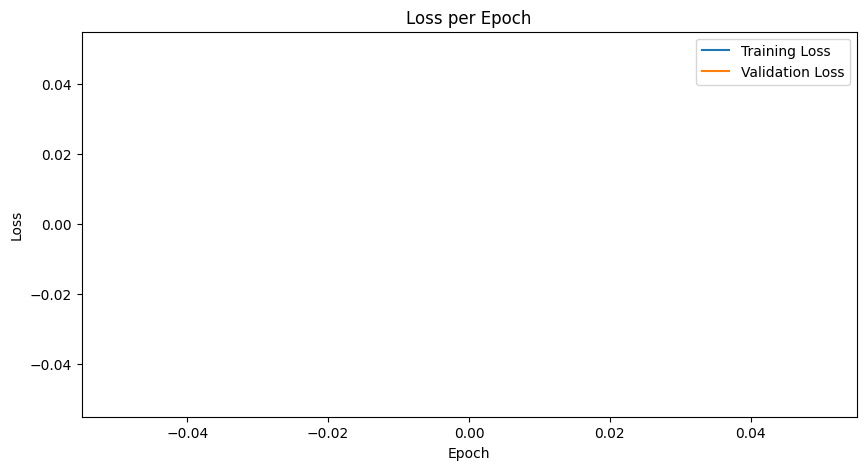

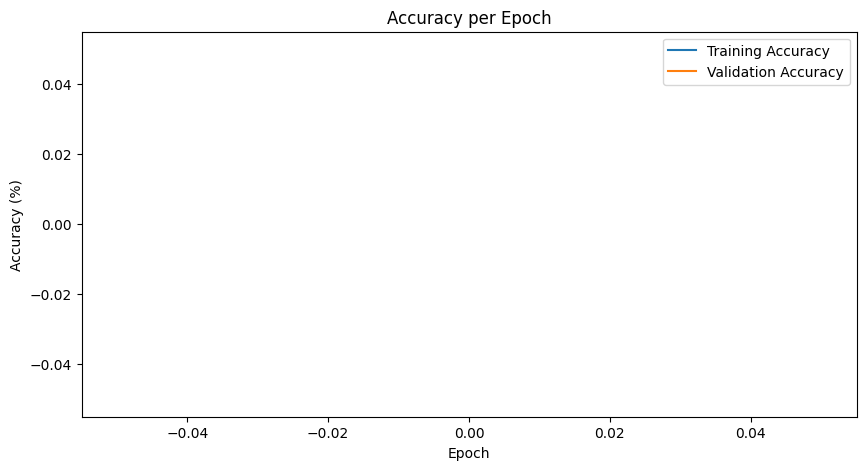

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
# Evaluation on test data
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=datasets['test'].classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=datasets['test'].classes, yticklabels=datasets['test'].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

NameError: name 'dataloaders' is not defined